# Tagup Data Science Exercise

ExampleCo, Inc is gathering several types of data for its fleet of very expensive machines.  These very expensive machines have three operating modes: *normal*, *faulty* and *failed*.   The machines run all the time, and usually they are in normal mode.  However, in the event that the machine enters faulty mode, the company would like to be aware of this as soon as possible.  This way they can take preventative action to avoid entering failed mode and hopefully save themselves lots of money.

They collect four kinds of timeseries data for each machine in their fleet of very expensive machines.  When a machine is operating in *normal* mode the data behaves in a fairly predictable way, but with a moderate amount of noise.  Before a machine fails it will ramp into *faulty* mode, during which the data appears visibly quite different.  Finally, when a machine fails it enters a third, and distinctly different, *failed* mode where all signals are very close to 0.

You can download the data here: [exampleco_data](https://drive.google.com/open?id=1b12u6rzkG1AxB6wLGl7IBVoaoSoZLHNR)

## Objectives 

1. **Your primary objective is to develop an approach to detect the beginning of the “faulty” period**. Ideally, this approach would give the ExampleCo engineers as much time as possible to shut down their machines before failure occurs (at which time all measurements drop close to 0). The best solutions are automated in the sense that they would generalize to similar but slightly different data; simpler methods are acceptable but are less likely to receive full credit.
2. Demonstrate the efficacy of your approach using visualizations. You must also include a simple explanation of these figures and why your approach is effective, ideally written in language that non-technical executives could understand.
3. Finally, and now with a technical audience in mind, discuss the strengths and limitations of your approach and be sure to mention other approaches that you would have liked to try if you had more time.


## Notes to help
1. A good place to start is by addressing the noise due to communication
   errors.
2. Feel free to use any libraries you like. Your final results should be
   presented in this Python notebook.
3. There are no constraints on the techniques you bring to bear, we are curious
   to see how you think and what sort of resources you have in your toolbox.
4. **Be sure to clearly articulate what you did, why you did it, and how the
   results should be interpreted**. In particular, you should be aware of the
   limitations of whatever approach or approaches you take.
5. Don't feel compelled to use all the data if you're not sure how. Feel free
   to focus on data from a single unit if that makes it easier to get started.
6. Don't hesitate to reach out to datasciencejobs@tagup.io with any questions!

# My solution

# Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact

# Let's first look at the data for a single machine and do some EDA

In [2]:
data = pd.read_csv('data/machine_0.csv',index_col=0)

data.head()

,0,1,2,3
2019-01-01 00:00:00.000000000,12.626096,8.803120,-11.809200,10.083961
2019-01-01 08:00:09.603201067,10.831994,2.816327,11.554778,21.892853
2019-01-01 16:00:19.206402134,21.083510,-0.672645,-17.839178,-1.349024
2019-01-02 00:00:28.809603201,32.294495,6.525132,-13.498586,-4.250752
2019-01-02 08:00:38.412804268,28.057100,3.691359,21.984744,13.670561


As expected there are 4 time-series data from sensors that appear to be taken at 8 hour intervals (index of the dataframe)

In [3]:
data.describe()

,0,1,2,3
count,3000.000000,3000.000000,3000.000000,3000.000000
mean,-0.816016,-1.091308,1.267945,0.165844
std,58.078319,55.965665,56.538700,56.910659
min,-323.954437,-258.780879,-287.153920,-365.362164
25%,-0.008684,-0.008851,-0.008274,-0.007883
50%,-0.000402,-0.000085,0.000669,0.000310
75%,0.007832,0.008373,0.009056,0.008685
max,315.738951,264.374782,281.684102,340.513819


There are 3000 data points for this particular machine and no missing values. Now let's visualize this for a single sensor

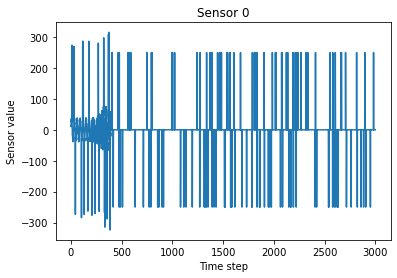

In [16]:
sensor = '0'
plt.plot(range(len(data)), data[sensor])
plt.xlabel('Time step')
plt.ylabel('Sensor value')
plt.title('Sensor '+sensor)
plt.show()

84.25862779528373

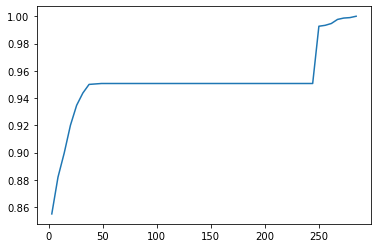

In [69]:
counts, bins = np.histogram(abs(data['2']), bins=50)

plt.plot((bins[:-1]+bins[1:])/2, np.cumsum(counts)/len(data))

np.percentile(abs(data['0']), 95)

As we see, the data is quite spiky. This is probably due to thet communications errors mentioned in the beginning. Let's try to deal with this

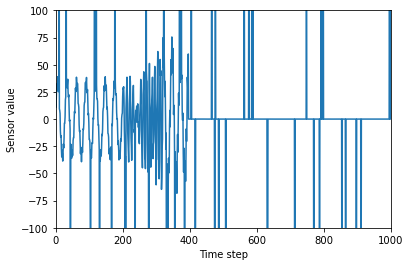

In [20]:
plt.plot(range(len(data)), data['0'])
plt.xlabel('Time step')
plt.ylabel('Sensor value')
plt.ylim(-100, 100)
plt.xlim(0, 1000)
plt.show()

In [ ]:
data[]

In [38]:
a = data['0'].copy()

(0.0, 600.0)

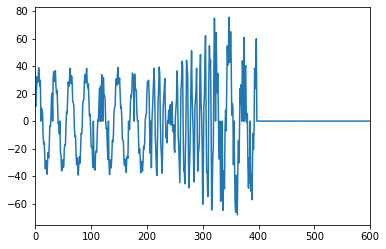

In [44]:
a[abs(a) > 100] = 0

plt.plot(range(len(a)), a)
plt.xlim(0, 600)